In [1]:
#=====[ Import dependencies ]====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('data')

#=====[ Import Data ]=====
import coords2 as cd
import coordKeys as keys

%matplotlib inline

#Step 1: Import Data

In [2]:
#=====[ Get data from python file and place in DataFrame ]=====
data = cd.data
df = pd.DataFrame(data,columns=keys.columns)

#Step 2: Isolate Individual Squats

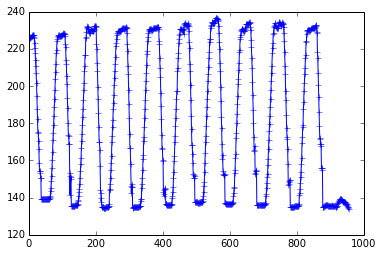

In [3]:
#=====[ Extract y_coords for Neck -- provides a stable point of reference ]=====
y_coords = [coord for coord in df['NeckY']]
plt.plot(y_coords,marker='+')

#Get Max Indices

In [6]:
def is_min(y_coords, height, gradient, index, epsilon, beta):
    if np.abs(y_coords[index] - height)/height < epsilon:
        for i in range(1,beta):
            if gradient[index - i] > 0 or gradient[index + i - 1] < 0:
                return False
        return True
        
def in_new_squat(y_coords, height, index, delta):
    return abs((y_coords[index] - height)/height) > delta

#=====[ Gets local maxes within accepted epsilon of global max and with max len(y_coors)/gamma maxes ]=====
def get_local_mins(y_coords, epsilon=0.05, gamma=20, delta=0.5, beta=1):
    
    local_mins = []
    height = np.min(y_coords)
    gradient = np.gradient(y_coords)
    
    #=====[ Checks gradients to make sure  ]=====
    min_located = False
    for index, dy in enumerate(gradient[2:]):
        if(min_located):
            if in_new_squat(y_coords, height, index, delta):
                min_located = False       
            else:
                continue
                
        if  is_min(y_coords, height, gradient, index, epsilon, beta + 1):
            local_mins.append(index)
            min_located = True
        
    return sorted(local_mins)

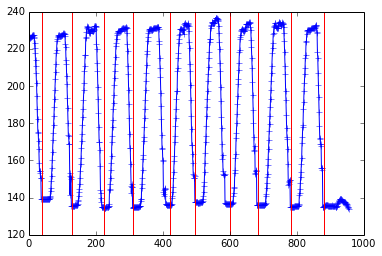

In [7]:
#=====[ Get maxes and plot with y_coords ]=====
mins = get_local_mins(y_coords)
plt.plot(y_coords,marker='+')

for divide in mins:
    plt.axvline(divide,color='r')

#Separate Squats based on max points found

In [8]:
squats = []

#=====[ Get points from DF between each max found -- constitutes a single squat ]=====
for index,x in enumerate(mins):
    if(index == len(mins) -1 ):
        continue
    squats.append(df[x:mins[index+1]])
    

#Step 3: Normalize Coordinates

In [9]:
def y_upper_bound(df):
    return np.min(df['HeadY'])

In [10]:
def y_lower_bound(df):
    return np.median(pd.concat([df['FootRightY'],df['FootLeftY']],axis =0))

In [11]:
def x_zero(df):
    return np.median(df['SpineMidX'])

In [12]:
def scaling_factor(df):
    return np.abs(y_upper_bound(df) - y_lower_bound(df))

In [13]:
for squat in squats:
    
    #=====[ Get normalizing constants ]=====
    y_head = y_upper_bound(squat)
    scale = scaling_factor(squat)
    x_midpoint = x_zero(squat)
    
    #=====[ Even columns are x-coordinates, odd columns are y-coordinates -- normalize respectively ]=====
    for index, col in enumerate(squat.columns):
        if index % 2 == 1:
            squat[col] = squat[col].apply(lambda y: ((y - y_head)/scale))
        else:
            squat[col] = squat[col].apply(lambda x: (x - x_midpoint))

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


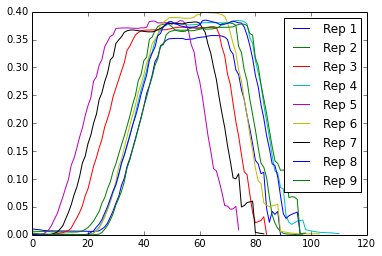

In [14]:
#=====[ Visual comparison between reps ]=====
for index, squat in enumerate(squats):
    plt.plot([coord for coord in squat['HeadY']],label="Rep " + str(index + 1))
plt.legend()

#Visualize Scaled Body

In [15]:
def plotBody(df,frame):
    coords = np.array(df.iloc[[frame]])
    xs = [coords[0][i] for i in range(0,coords.size) if i % 2 == 0]
    ys = [-1*coords[0][i] for i in range(0,coords.size) if i % 2 == 1]
    plt.plot(xs,ys,linestyle='None',marker='o')

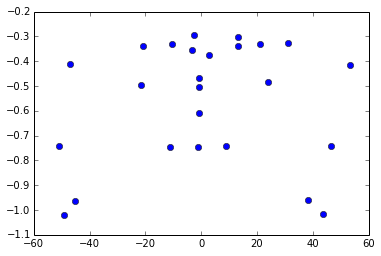

In [16]:
plotBody(squats[1],50)